In [57]:
 !nvidia-smi

Thu Apr 17 13:51:04 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   48C    P0             28W /   70W |     312MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [58]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms

# This mounts your google drive storage to this code
from google.colab import drive
drive.mount('/content/gdrive')


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [59]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

root = '/content/gdrive/My Drive/Test/'

# root = './'
# if not os.path.exists(root):
#     os.makedirs(root)

Using cuda device


In [60]:
# settings for data normalization
#trans = transforms.Compose([transforms.ToTensor(),
     #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
# trans = transforms.ToTensor()
# trans = transforms.Compose([transforms.ToTensor(), transforms.RandomHorizontalFlip()])

# CIFAR-10 공식 채널별 평균/표준편차
cifar10_mean = (0.4914, 0.4822, 0.4465)
cifar10_std  = (0.2470, 0.2435, 0.2616)

# 1) 학습용 전처리: 랜덤 크롭+패딩, 좌우반전, 컬러 지터 등
train_trans = transforms.Compose([
    # 32×32 이미지를 4픽셀만큼 패딩한 뒤 32×32 영역을 랜덤 크롭
    transforms.RandomCrop(32, padding=4),
    # 50% 확률로 좌우 반전
    transforms.RandomHorizontalFlip(),
    # 밝기·대비·채도 약간씩 변경
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    # 채널별 평균/표준편차로 정규화
    transforms.Normalize(cifar10_mean, cifar10_std),
])

# 2) 검증/테스트용 전처리: 증강 없이 정규화만
test_trans = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(cifar10_mean, cifar10_std),
])

# DataLoader 세팅
train_data = datasets.CIFAR10(
    root=root,
    train=True,
    download=True,
    transform=train_trans,
)

test_data = datasets.CIFAR10(
    root=root,
    train=False,
    download=True,
    transform=test_trans,
)

batch_size = 50
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=2)


In [ ]:
# Linear Classification
'''
class LinearClassification(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear = nn.Sequential(
            nn.Linear(28*28, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear(x)
        return logits

model = LinearClassification().to(device)
print(model)
'''


LinearClassification(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear): Sequential(
    (0): Linear(in_features=784, out_features=10, bias=True)
  )
)


In [ ]:
# # Multi-layer Perceptron
'''
class NeuralNetwork(nn.Module):
     def __init__(self):
         super().__init__()
         self.flatten = nn.Flatten()
         self.linear_relu_stack = nn.Sequential(
             nn.Linear(28*28, 512),
             nn.ReLU(),
             nn.Linear(512, 512),
             nn.ReLU(),
             nn.Linear(512, 10)
         )

     def forward(self, x):
         x = self.flatten(x)
         logits = self.linear_relu_stack(x)
         return logits

 model = NeuralNetwork().to(device)
 print(model)
'''

In [61]:
# define the CNN:
# two convolution layers followed by two linear layers

class MyConvNet(nn.Module):   # nn.Module should be inherited for the neural network configuration so that it can work with backpropagation APIs
     def __init__(self):    # define layers: two conv layers and two linear (fully connected) layers
         super(MyConvNet, self).__init__()
         self.conv_layers = nn.Sequential(
             # Conv1: 3 입력, 32 출력, 커널 크기 3x3, padding 1
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),  # Batch Normalization 추가
            nn.MaxPool2d(2, 2),  # 2x2 MaxPooling

            # Conv2: 32 입력, 64 출력, 커널 크기 3x3, padding 1
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),  # Batch Normalization 추가
            nn.MaxPool2d(2, 2),  # 2x2 MaxPooling

            # Conv3: 64 입력, 128 출력, 커널 크기 3x3, padding 1
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128), # Batch Normalization 추가
            nn.MaxPool2d(2, 2),  # 2x2 MaxPooling

            # Conv4: 128 입력, 256 출력, 커널 크기 3x3, padding 1
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256), # Batch Normalization 추가
            nn.MaxPool2d(2, 2),  # 2x2 MaxPooling

            nn.Flatten(),
            nn.Linear(256 * 2 * 2, 512),
            nn.ReLU(),
            nn.Dropout(0.5),  # Dropout 추가로 과적합 방지

            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.5),  # Dropout 추가로 과적합 방지

            nn.Linear(256, 10)
         )

     # network connection: two conv layers, each followed by relu and max-pooling with (2x2) kernel, and two linear layer
     def forward(self, x):
         logits = self.conv_layers(x)
         return(logits)


 # generate neural net model
model = MyConvNet().to(device)
print(model)


MyConvNet(
  (conv_layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track

In [62]:
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
# 학습률을 동적으로 조정하여 더 빠르고 효율적으로 학습
# 10 epoch 마다 0.7 만큼 학습률 조정
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.7)

criterion = nn.CrossEntropyLoss()

In [63]:
# training and test

# epoch: 30
# data dimension: batch_size x Channels x Height x Width (NCHW)
for epoch in range(30):
    # training phase
    model.train() # 학습 모드
    current_loss= 0.0
    for batch_num, (x, target) in enumerate(train_loader):
        x, target = x.to(device), target.to(device)

        out = model(x)
        loss = criterion(out,target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        current_loss += loss

        # display the training loss in every 100 batches
        if (batch_num+1)%100 == 0 or (batch_num+1)%100 == len(train_loader):
            print('epoch: %d, batch_num: %d, current_loss: %.3f' %(epoch, batch_num+1, current_loss/100))
            current_loss = 0.0

    # scheduler.step()를 호출하여 학습률 업데이트
    scheduler.step()  # 학습률을 업데이트하는 부분

    # test phase
    with torch.no_grad():
        model.eval() # 평가 모드
        total_samples = 0.0
        correct_samples = 0.0
        for (x, target) in test_loader:
            x, target = x.to(device), target.to(device)
            out = model(x)
            pred = torch.argmax(out,1)
            correct_samples += (pred == target).sum()
        print('Accuracy: %.3f' %(100*float(correct_samples) / float(len(test_data))))




epoch: 0, batch_num: 100, current_loss: 2.008
epoch: 0, batch_num: 200, current_loss: 1.763
epoch: 0, batch_num: 300, current_loss: 1.648
epoch: 0, batch_num: 400, current_loss: 1.569
epoch: 0, batch_num: 500, current_loss: 1.483
epoch: 0, batch_num: 600, current_loss: 1.430
epoch: 0, batch_num: 700, current_loss: 1.392
epoch: 0, batch_num: 800, current_loss: 1.335
epoch: 0, batch_num: 900, current_loss: 1.282
epoch: 0, batch_num: 1000, current_loss: 1.269
Accuracy: 62.520
epoch: 1, batch_num: 100, current_loss: 1.229
epoch: 1, batch_num: 200, current_loss: 1.189
epoch: 1, batch_num: 300, current_loss: 1.148
epoch: 1, batch_num: 400, current_loss: 1.162
epoch: 1, batch_num: 500, current_loss: 1.100
epoch: 1, batch_num: 600, current_loss: 1.115
epoch: 1, batch_num: 700, current_loss: 1.089
epoch: 1, batch_num: 800, current_loss: 1.112
epoch: 1, batch_num: 900, current_loss: 1.058
epoch: 1, batch_num: 1000, current_loss: 1.106
Accuracy: 67.280
epoch: 2, batch_num: 100, current_loss: 1.01

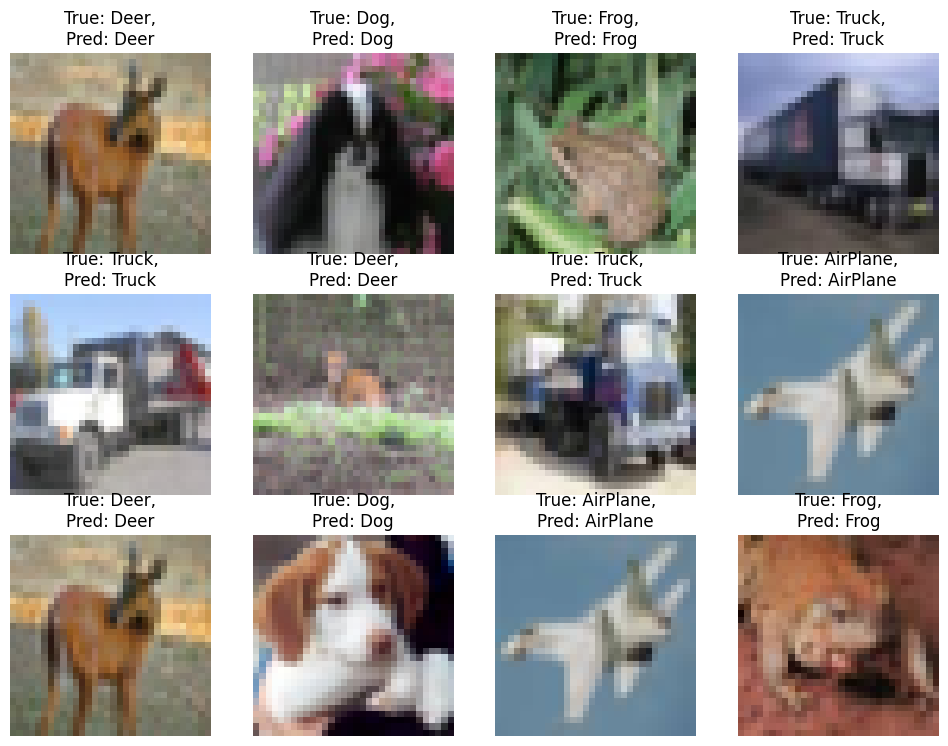

In [67]:
# CIFAR-10 정규화에 사용된 평균과 표준편차
mean = [0.4914, 0.4822, 0.4465]
std = [0.2470, 0.2435, 0.2616]

# 역정규화 함수 정의
def unnormalize(img):
    for i in range(3):  # RGB 채널 순서대로 처리
        img[i] = img[i] * std[i] + mean[i]
    return img

# Display Some test results
import numpy as np
import matplotlib.pyplot as plt

classes = [
    "AirPlane",
    "Automobile",
    "Bird",
    "Cat",
    "Deer",
    "Dog",
    "Frog",
    "Horse",
    "Ship",
    "Truck",
]

# take one batch of the data
test_data, test_labels = next(iter(test_loader))

# if cuda_available:
test_data, test_labels = test_data.to(device), test_labels.to(device)
out = model(test_data)              # put the test data to the trained network
pred = torch.argmax(out,1)          # prediction to the highest probability


sample_index = np.random.choice(batch_size, size=12)     # take 12 random sample index
num_samples = sample_index.size

random_samples = test_data[sample_index].cpu().numpy()

plt.figure(figsize=(12, 12))

# display test samples
for k in range(num_samples):
    plt.subplot(4, 4, k + 1)
    # 역정규화 후 이미지 표시
    img = unnormalize(random_samples[k])
    plt.imshow(random_samples[k].transpose(1, 2, 0))
    plt.title("True: " + str( classes[test_labels[sample_index[k]].item()]) + ",\nPred: " + str(classes[pred[sample_index[k]].item()]))
    plt.axis('off')


plt.show()

In [68]:
# save model
torch.save(model, root + 'my_CNN_model.pth')

# load model
# model = torch.load('my_CNN_model.pth')

In [ ]:
# # save model weights
# torch.save(model.state_dict(), 'model_weights.pth')

# # load model weights
# model = MyConvNet()
# model.load_state_dict(torch.load('model_weights.pth'))
